In [1]:
import numpy as np
import matplotlib.pyplot as plt
from src.sqr_gaussian_inference import * 
from src.gaussian_inference import *

Bad value in file 'matplotlibrc', line 55 ("axes.prop_cycle: cycler('color', ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'])"): Key axes.prop_cycle: "cycler('color', ['" is not a valid cycler construction: unterminated string literal (detected at line 1) (<unknown>, line 1)


In [29]:
#ODE - IVP:
vf = lambda x: x*(1-x)
y0 = 0.01

#exact solution:
x_exact = lambda t: 1 / (1 + (1 / 0.01 - 1) * np.exp(-t))
x_prime_exact = lambda t: (1 / 0.01 - 1) * np.exp(-t) / (1 + (1 / 0.01 - 1) * np.exp(-t))**2
x_prime_prime_exact = lambda t: x_exact(t)*(1-x_exact(t))*(1-2*x_exact(t))
exact_sols = [x_exact, x_prime_exact, x_prime_prime_exact]

#Prior
A = lambda h: np.array([[1, h, h**2/2], [0, 1, h], [0, 0, 1]])
sigma = 1.0
Q = lambda h: sigma**2 * np.array([[h**5/20, h**4/8, h**3/6], [h**4/8, h**3/3, h**2/2], [h**3/6, h**2/2, h]])
X_0 = np.array([y0, vf(y0), (1-y0)*(1-2*y0)*y0])
mu_0 = X_0
Sigma_0 = np.eye(3)*0.

#Discretization
t0, t1 = 0.0, 10.0
N = 22
ts = np.linspace(t0, t1, num=N+1, endpoint=True)
t = np.linspace(t0,t1, 100)
h = (t1 - t0) / N


#Consequences of constant step size
A_h = A(h)
Q_h = Q(h)
b_h = np.zeros(3)
R_h = np.array([[0.0]])

#Measurement operator
g = lambda X: np.array([X[1] - vf(X[0])])
jacobian_g = lambda X: np.array([[-1*X[0]*(1 - 2*X[0]), 1, 0]])

#Data
z_sequence = np.zeros(N).reshape(-1,1)

In [30]:
#single step of a kalman filter
def ekf1_filter_step(A_t, b_t, Q_t, R_t, mu_t, Sigma_t, g, jacobian_g, z_observed):

    m_pred, P_pred = marginalization(A_t, b_t, Q_t, mu_t, Sigma_t)

    #linearize the observation model
    H_t = jacobian_g(m_pred)
    c_t = g(m_pred) - H_t @ m_pred

    # predict/estimate the next observationm: p(z_n|x_n)
    #z_expected, S_sqr = sqr_marginalization(H_n, c, R_h, m_next, P_next_sqr)

    #compute backward transition: p(z_n|x_n)
    #this actually implicitly first computes the observation estimate which is why the above line is commented

    #observe z:
    m_updated, P_updated = inversion(H_t, c_t, R_t, m_pred, P_pred, z_observed)
    
    return (m_pred, P_pred), (m_updated, P_updated)

In [31]:
#single step of a kalman filter
def ekf1_filter_step_stable(A_t, b_t, Q_t, R_t, mu_t, Sigma_t, g, jacobian_g, z_observed):

    m_pred, P_pred = sqr_marginalization(A_t, b_t, Q_t, mu_t, Sigma_t)

    #linearize the observation model
    H_t = jacobian_g(m_pred)
    c_t = g(m_pred) - H_t @ m_pred

    # predict/estimate the next observationm: p(z_n|x_n)
    #z_expected, S_sqr = sqr_marginalization(H_n, c, R_h, m_next, P_next_sqr)

    #compute backward transition: p(z_n|x_n)
    #this actually implicitly first computes the observation estimate which is why the above line is commented

    #observe z:
    m_updated, P_updated = sqr_inversion(H_t, c_t, R_t, m_pred, P_pred, z_observed)
    
    return (m_pred, P_pred), (m_updated, P_updated)

In [32]:
def compute_kalman_forward_stable(mu_0, Sigma_0, A_h, b_h, Q_h, R_h, g, jacobian_g, z_sequence, N):
    #complete forward kalman filtering pass:
    #Q_h = np.linalg.cholesky(Q_h)
    #R_h = np.linalg.cholesky(R_h)
    #Sigma_0 = np.linalg.cholesky(Sigma_0)
    
    
    m_sequence = [mu_0]
    P_sequence = [Sigma_0] 
    m_predictions = []
    P_predictions = []

    for i in range(N):
        #this index correspnds to the timestep 
        #print(ts[i+1])
        #h = ts[i+1]-ts[i]
        (m_pred_nxt, P_pred_nxt), (m_nxt, P_nxt) = ekf1_filter_step_stable(A_h, b_h, Q_h, R_h, m_sequence[-1], P_sequence[-1], g, jacobian_g, z_sequence[i,:])
        m_sequence.append(m_nxt)
        P_sequence.append(P_nxt)
        m_predictions.append(m_pred_nxt)
        P_predictions.append(P_pred_nxt)


    m_sequence = np.array(m_sequence)
    P_sequence = np.array(P_sequence)
    m_predictions = np.array(m_predictions)
    P_predictions = np.array(P_predictions)

        # Important: square covariances 
    for i in range(P_sequence.shape[0]):
        P_sequence[i,...] = P_sequence[i,...].T @ P_sequence[i,...]

        # Important: square covariances 
    for i in range(P_predictions.shape[0]):
        P_predictions[i,...] = P_predictions[i,...].T @ P_predictions[i,...]

    return m_sequence, P_sequence, m_predictions, P_predictions


def compute_kalman_forward(mu_0, Sigma_0, A_h, b_h, Q_h, R_h, g, jacobian_g, z_sequence, N):
    #complete forward kalman filtering pass:
    m_sequence = [mu_0]
    P_sequence = [Sigma_0] 
    m_predictions = []
    P_predictions = []

    for i in range(N):
        #this index correspnds to the timestep 
        #print(ts[i+1])
        #h = ts[i+1]-ts[i]
        (m_pred_nxt, P_pred_nxt), (m_nxt, P_nxt) = ekf1_filter_step(A_h, b_h, Q_h, R_h, m_sequence[-1], P_sequence[-1], g, jacobian_g, z_sequence[i,:])
        m_sequence.append(m_nxt)
        P_sequence.append(P_nxt)
        m_predictions.append(m_pred_nxt)
        P_predictions.append(P_pred_nxt)


    m_sequence = np.array(m_sequence)
    P_sequence = np.array(P_sequence)
    m_predictions = np.array(m_predictions)
    P_predictions = np.array(P_predictions)

    return m_sequence, P_sequence, m_predictions, P_predictions


In [33]:
m_sequence, P_sequence, m_predictions, P_predictions = compute_kalman_forward(mu_0, Sigma_0, A_h, b_h, Q_h, R_h, g, jacobian_g, z_sequence, N)

In [34]:
def plot_graph(ts, m, P, t, x_exact):
    plt.figure(figsize=(10,5))
    plt.plot(t, x_exact(t), linestyle='--', color="black")
    plt.plot(ts, m, color='red')
    plt.scatter(ts, m, color='red')
    P_f_safe = np.maximum(P, 0)
    margin = np.sqrt(P_f_safe)
    plt.fill_between(ts,m-margin, m+margin, alpha=0.2, color='red')
    plt.show()

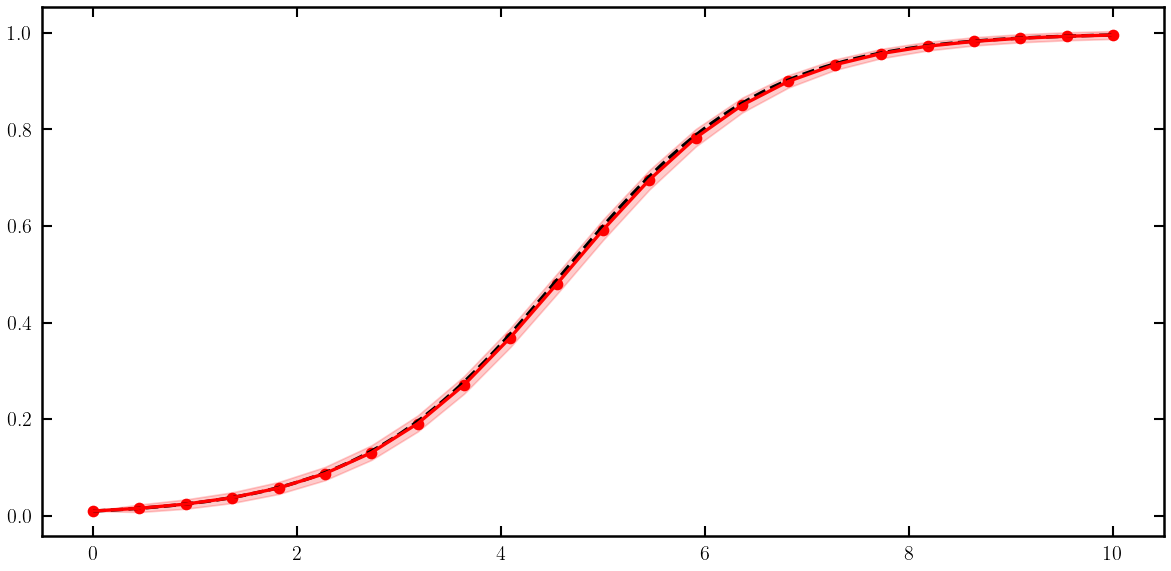

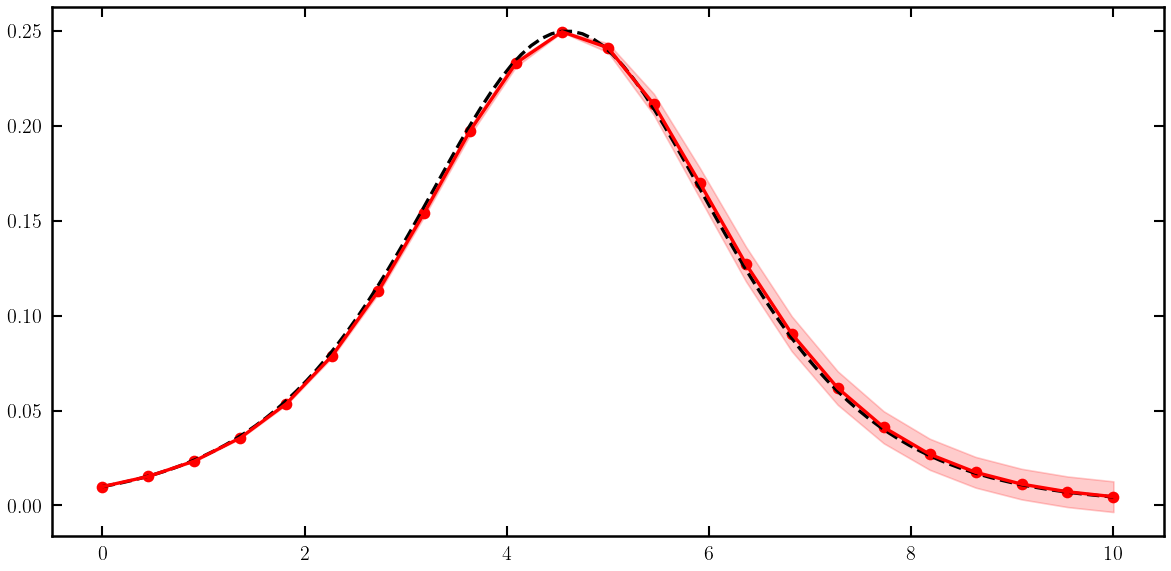

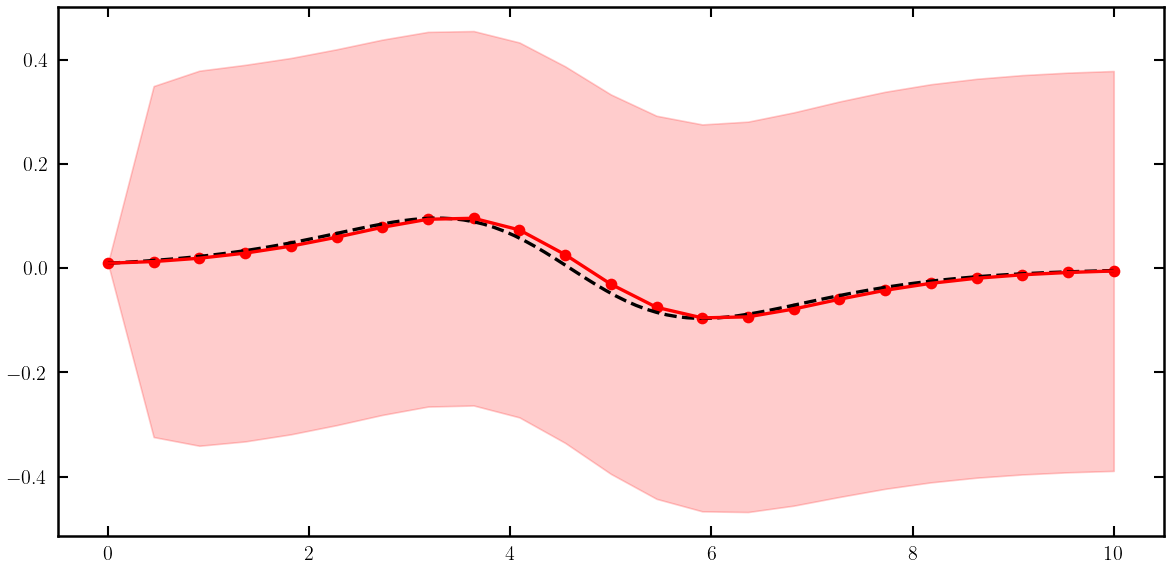

In [35]:
for k in range(3):
    plot_graph(ts, m_sequence[:,k], P_sequence[:,k,k], t, exact_sols[k])

### Compare stable sqr computed version with "unstable" version

In [36]:
m_sequence, P_sequence, m_predictions, P_predictions = compute_kalman_forward(mu_0, Sigma_0, A_h, b_h, Q_h, R_h, g, jacobian_g, z_sequence, N)

m_sequence2, P_sequence2, m_predictions2, P_predictions2 = compute_kalman_forward_stable(mu_0, Sigma_0, A_h, b_h, Q_h, R_h, g, jacobian_g, z_sequence, N)

In [37]:
def plot_graph2(ts, m, P, m2, P2, t, x_exact):
    plt.figure(figsize=(10,5))
    plt.plot(t, x_exact(t), linestyle='--', color="black")
    plt.plot(ts, m, color='red')
    plt.scatter(ts, m, color='red')
    P_f_safe = np.maximum(P, 0)
    margin = np.sqrt(P_f_safe)
    plt.fill_between(ts,m-margin, m+margin, alpha=0.2, color='red')

    plt.scatter(ts, m2, color='blue')
    plt.plot(ts, m2, color='blue')
    P_f_safe2 = np.maximum(P2, 0)
    margin2 = np.sqrt(P_f_safe2)
    plt.fill_between(ts,m2-margin2, m2+margin2, alpha=0.2, color='blue')
    plt.show()

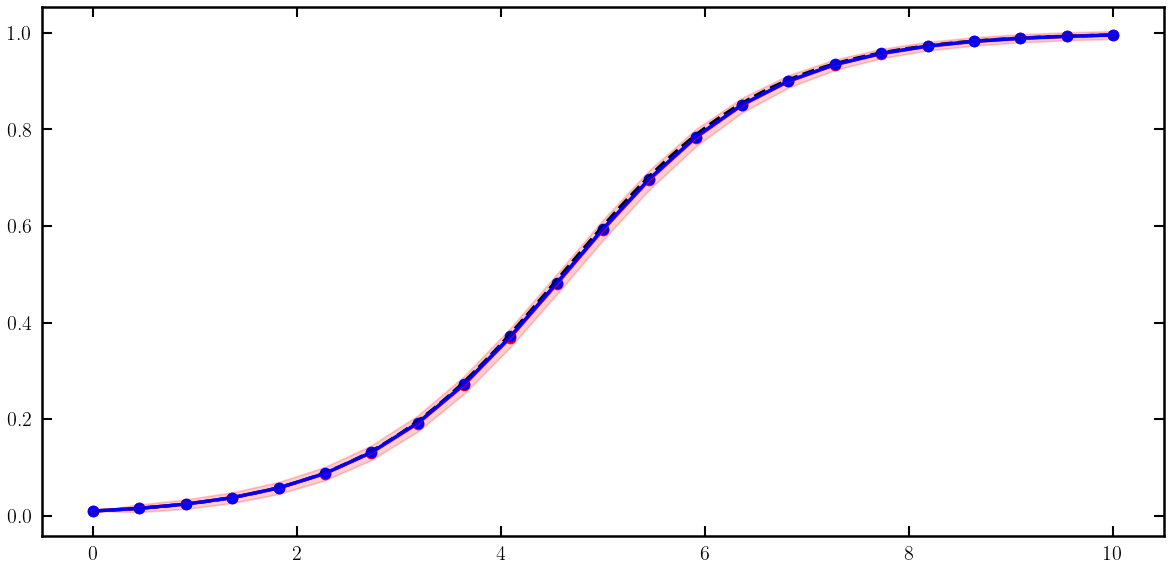

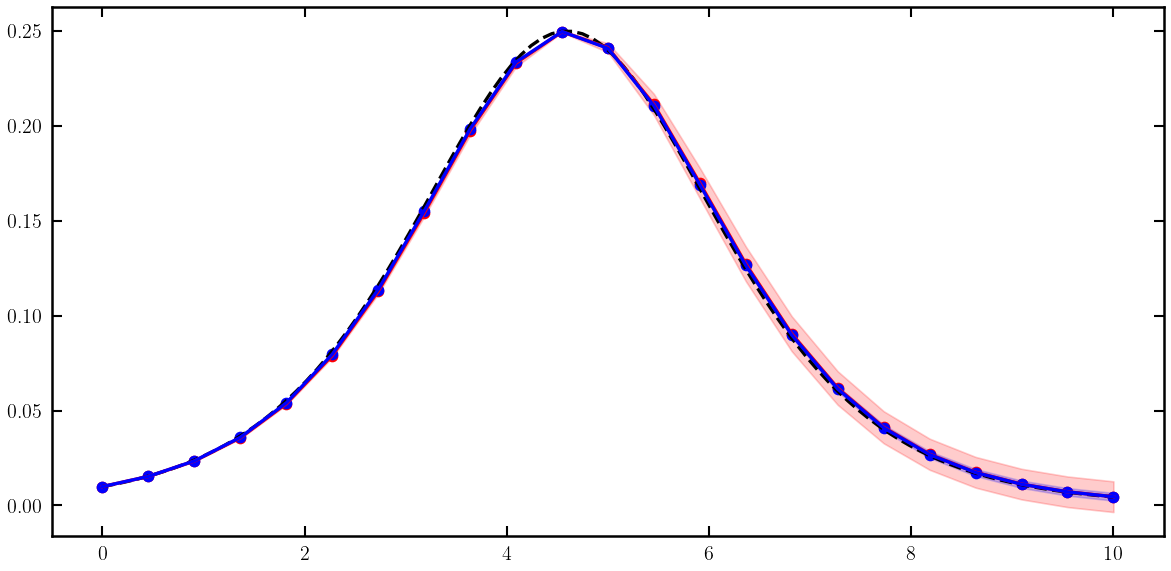

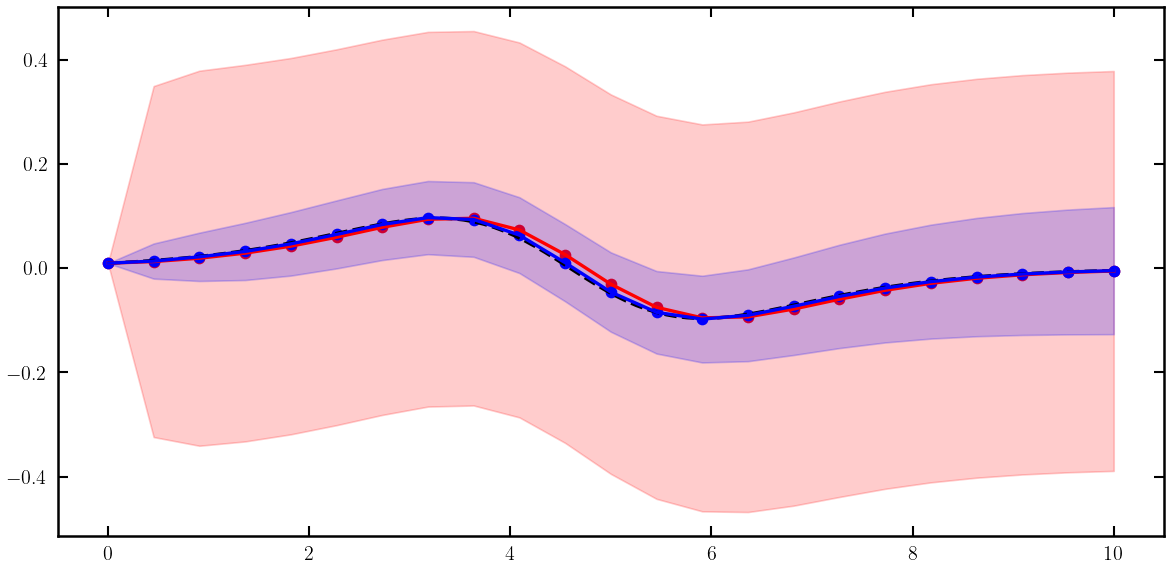

In [38]:
for k in range(3):
    plot_graph2(ts, m_sequence[:,k], P_sequence[:,k,k],m_sequence2[:,k], P_sequence2[:,k,k], t, exact_sols[k])

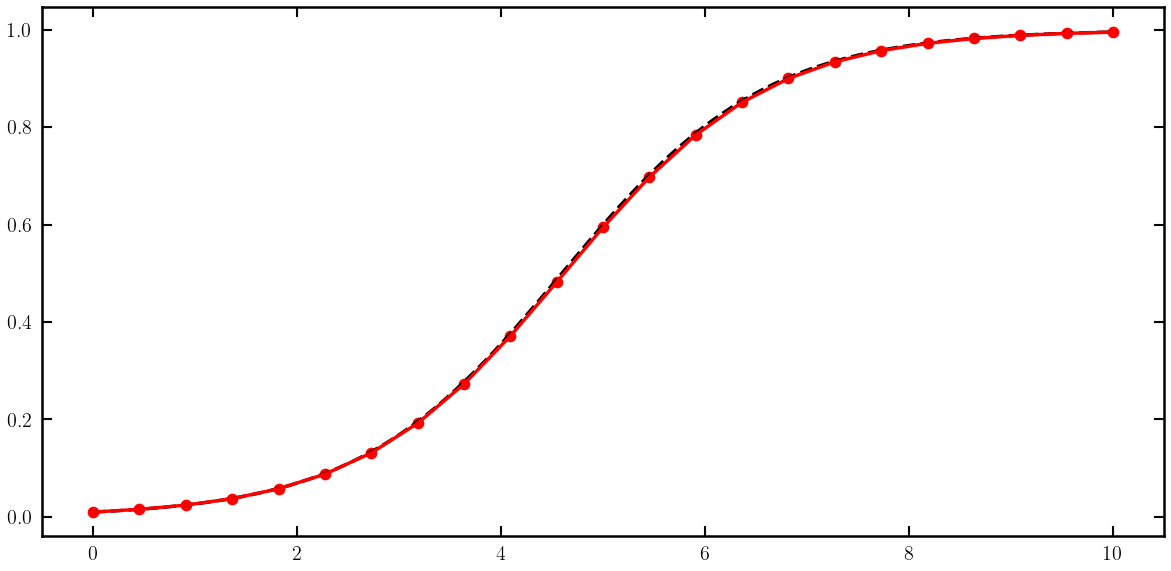

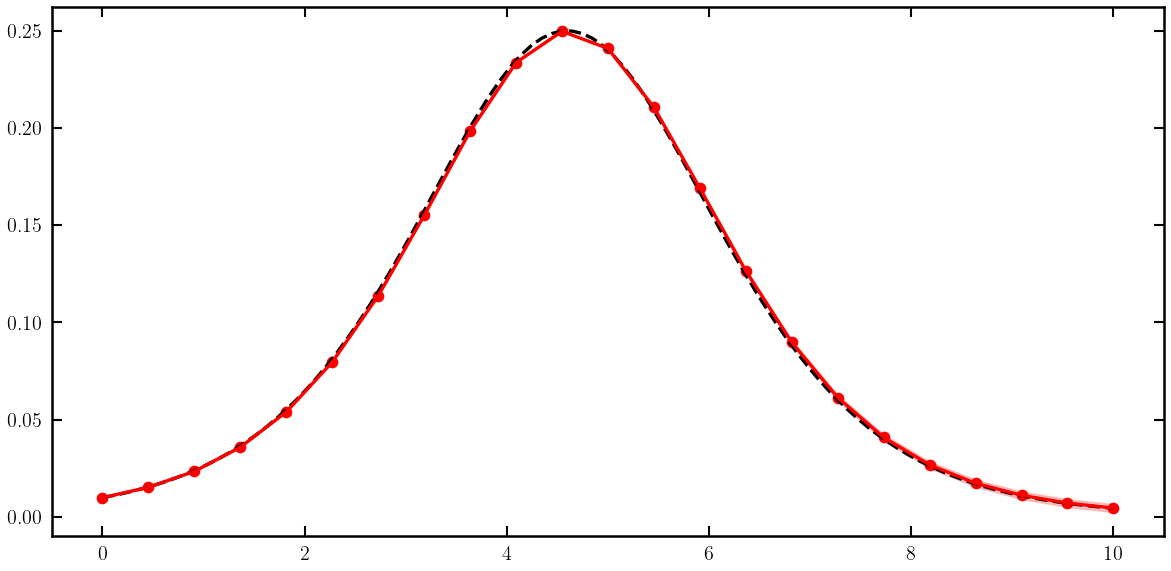

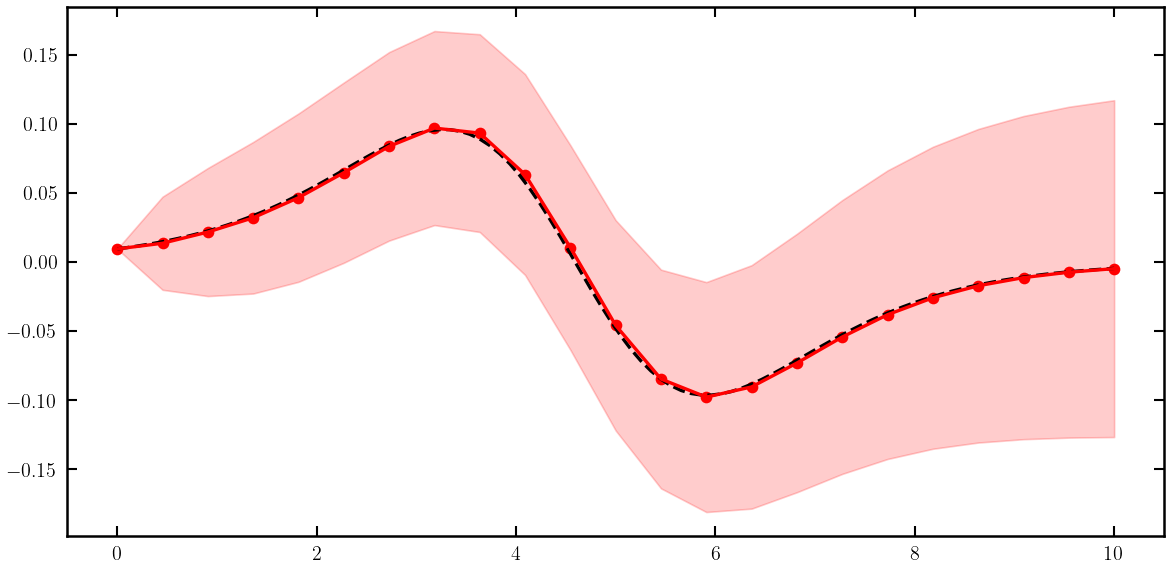

In [39]:
for k in range(3):
    plot_graph(ts, m_sequence2[:,k], P_sequence2[:,k,k], t, exact_sols[k])